# Librerias

In [1]:
# Instalamos TensorFlow y otras librerías necesarias si no están ya instaladas
!pip install tensorflow matplotlib pillow gdown

In [2]:
import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from keras.layers import Rescaling
from google.colab import drive

# Obtención de datos

In [3]:
# Descargar el archivo desde Google Drive
!gdown 'https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'

zip_path = '/content/TP1-3-natural-scenes.zip'  # Nombre del archivo descargado
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('scene_classification')  # Descomprimir en un directorio


Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=18f47a59-71ca-4760-94df-a3a0a5400ba6
To: /content/TP1-3-natural-scenes.zip
100% 363M/363M [00:02<00:00, 131MB/s]


In [4]:
# Verificamos la estructura de los datos
train_dir = '/content/scene_classification/seg_train/seg_train'
test_dir = '/content/scene_classification/seg_test/seg_test'
predict_dir = '/content/scene_classification/seg_pred/seg_pred'

print("Clases de entrenamiento:", os.listdir(train_dir))
print("Ejemplos en 'train/buildings':", len(os.listdir(os.path.join(train_dir, 'buildings'))))


Clases de entrenamiento: ['glacier', 'mountain', 'street', 'buildings', 'forest', 'sea']
Ejemplos en 'train/buildings': 2191


In [5]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Split de datos para el modelo de capas densas

In [6]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/scene_classification/seg_train/seg_train")
TEST_DATA_DIRECTORY = Path("/content/scene_classification/seg_test/seg_test")


# Tamaño del lote (batch size)
BATCH_SIZE = 32

# Tamaño de las imágenes
IMAGE_HEIGHT = 65
IMAGE_WIDTH = 65


# Dividir el dataset en entrenamiento y validación
train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    seed=123,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIRECTORY,
    seed=123,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)




Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [7]:
# Obtiene los nombres de las clases
class_names = train.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


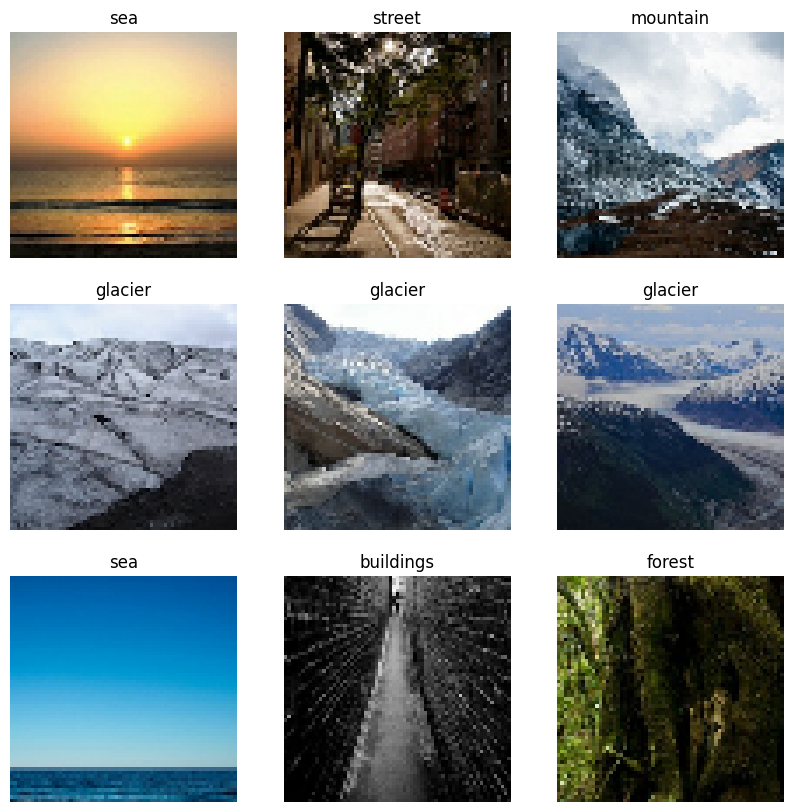

In [8]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Modelo con Capas Densas

In [9]:
dense_model = models.Sequential([
    layers.Flatten(input_shape=(65, 65, 3)),
    layers.Rescaling(1./255),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

dense_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

dense_history = dense_model.fit(train,
                                validation_data=val,
                                epochs=25,
                                batch_size=512)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.2703 - loss: 2.2311 - val_accuracy: 0.4567 - val_loss: 1.4253
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4175 - loss: 1.4567 - val_accuracy: 0.4797 - val_loss: 1.3822
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4609 - loss: 1.3746 - val_accuracy: 0.5027 - val_loss: 1.3134
Epoch 4/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4948 - loss: 1.3103 - val_accuracy: 0.5327 - val_loss: 1.2693
Epoch 5/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5100 - loss: 1.2729 - val_accuracy: 0.5387 - val_loss: 1.2790
Epoch 6/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5318 - loss: 1.2361 - val_accuracy: 0.5457 - val_loss: 1.2293
Epoch 7/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5484 - loss: 1.1953 - val_accuracy: 0.5037 - val_loss: 1.3446
Epoch 8/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5584 - loss: 1.1742 - val_accuracy: 0

# Split de datos para el modelo de capas densas

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


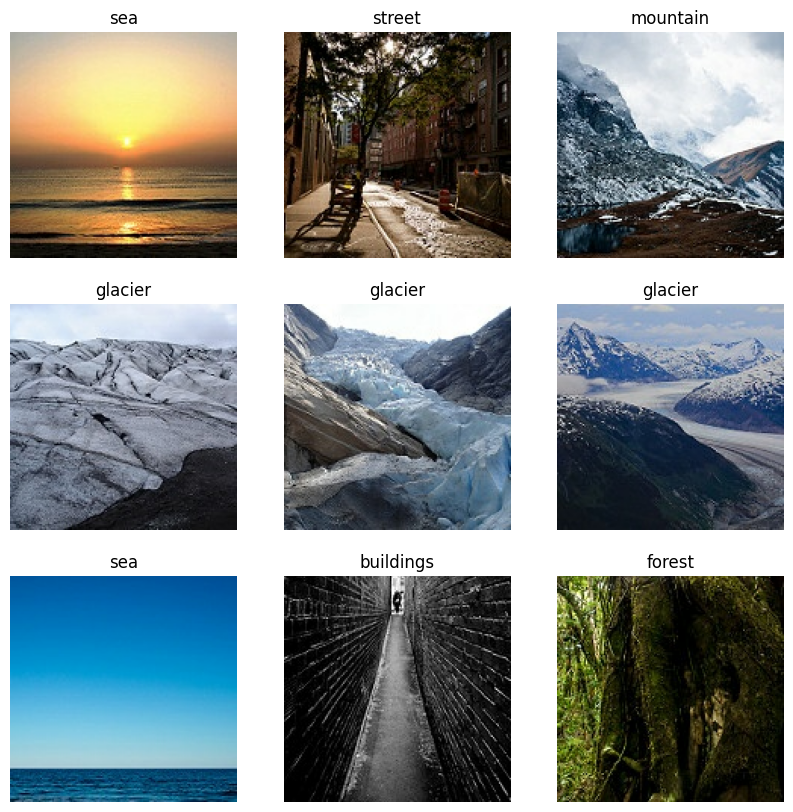

In [10]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/scene_classification/seg_train/seg_train")
TEST_DATA_DIRECTORY = Path("/content/scene_classification/seg_test/seg_test")


# Tamaño del lote (batch size)
BATCH_SIZE = 32

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150


# Dividir el dataset en entrenamiento y validación
train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    seed=123,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIRECTORY,
    seed=123,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Obtiene los nombres de las clases
class_names = train.class_names
num_classes = len(class_names)
print(class_names)

# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Modelo con capas convolucionales y densas

In [ ]:
cnn_model = models.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(12, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(12, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(6, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_history = cnn_model.fit(train,
                            epochs=25,
                            validation_data=val)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.3147 - loss: 1.6104 - val_accuracy: 0.5403 - val_loss: 1.1510
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5081 - loss: 1.1815 - val_accuracy: 0.6340 - val_loss: 1.0131
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5492 - loss: 1.0681 - val_accuracy: 0.6487 - val_loss: 0.9187
Epoch 4/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5758 - loss: 1.0146 - val_accuracy: 0.6400 - val_loss: 0.8977
Epoch 5/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5852 - loss: 0.9773 - val_accuracy: 0.6490 - val_loss: 0.8573
Epoch 6/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5907 - loss: 0.9661 - val_accuracy: 0.6550 - val_loss: 0.8819
Epoch 7/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6008 - loss: 0.9418 - val_accuracy: 0.6773 - val_loss: 0.8215
Epoch 8/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6096 - loss: 0.9266 - val_accuracy: 0.6

# Modelo con bloques residuales (ResNet)

In [12]:
def residual_block(x, filters, downsample=False):
    shortcut = x
    strides = 2 if downsample else 1

    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)

    if downsample or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

input_layer = layers.Input(shape=(150, 150, 3))
x = Rescaling(1./255)(input_layer)
x = layers.Conv2D(64, (7, 7), strides=2, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# Bloques residuales
x = residual_block(x, 64)
x = residual_block(x, 128, downsample=True)
x = residual_block(x, 128)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(24, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(6, activation='softmax')(x)

resnet_model = models.Model(inputs=input_layer, outputs=output_layer)

resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

resnet_history = resnet_model.fit(train,
                                  epochs=25,
                                  validation_data=val)

Epoch 1/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.2262 - loss: 1.7203 - val_accuracy: 0.4773 - val_loss: 1.3317
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.4250 - loss: 1.3355 - val_accuracy: 0.5347 - val_loss: 1.1608
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5082 - loss: 1.1942 - val_accuracy: 0.6007 - val_loss: 0.9868
Epoch 4/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5317 - loss: 1.1154 - val_accuracy: 0.6740 - val_loss: 0.8517
Epoch 5/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5712 - loss: 1.0456 - val_accuracy: 0.7117 - val_loss: 0.7888
Epoch 6/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5919 - loss: 0.9937 - val_accuracy: 0.6927 - val_loss: 0.8307
Epoch 7/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6179 - loss: 0.9446 - val_accuracy: 0.6973 - val_loss: 0.8028
Epoch 8/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6554 - loss: 0.8763 - 

# Transfer learning (ResNet50)

In [16]:
# Definir la entrada
input_layer = layers.Input(shape=(150, 150, 3))

# Preprocesamiento específico de ResNet50
x = tf.keras.applications.resnet50.preprocess_input(input_layer)

# Usar el modelo preentrenado ResNet50 sin la capa superior
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Congelamos las capas base

# Pasar las entradas preprocesadas a través del modelo base
x = base_model(x)

# Añadir capas adicionales para la clasificación
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(6, activation='softmax')(x)

# Crear el modelo
tl_model = models.Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
tl_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Entrenar el modelo
tl_history = tl_model.fit(train,
                          epochs=25,
                          validation_data=val)

Epoch 1/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.8274 - loss: 3.3289 - val_accuracy: 0.9037 - val_loss: 0.4025
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9043 - loss: 0.3735 - val_accuracy: 0.9103 - val_loss: 0.3259
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9095 - loss: 0.3189 - val_accuracy: 0.9177 - val_loss: 0.3131
Epoch 4/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.9213 - loss: 0.3037 - val_accuracy: 0.9200 - val_loss: 0.3456
Epoch 5/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9215 - loss: 0.2717 - val_accuracy: 0.9237 - val_loss: 0.2736
Epoch 6/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9334 - loss: 0.2270 - val_accuracy: 0.9243 - val_loss: 0.3114
Epoch 7/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9404 - loss: 0.2267 - val_accuracy: 0.9227 - val_loss: 0.3523
Epoch 8/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9450 - loss: 0.2013 - 

# Graficos comparativos

# Gráficos Comparativos de Rendimiento de Modelos

A continuación mostramos gráficos comparativos del rendimiento de los diferentes modelos entrenados:
 - modelo con capas densas,
 - modelo convolucional (CNN),
 - modelo con bloques residuales (ResNet) y
 - modelo utilizando aprendizaje por transferencia (Transfer Learning con ResNet50).

Se comparan dos métricas clave:

1. **Precisión en el conjunto de validación**: Nos da una idea de cuán bien está generalizando el modelo a datos que no ha visto antes.
2. **Pérdida en el conjunto de validación**: Mide cuán lejos están las predicciones del modelo del valor real esperado.


## Comparación de la Precisión

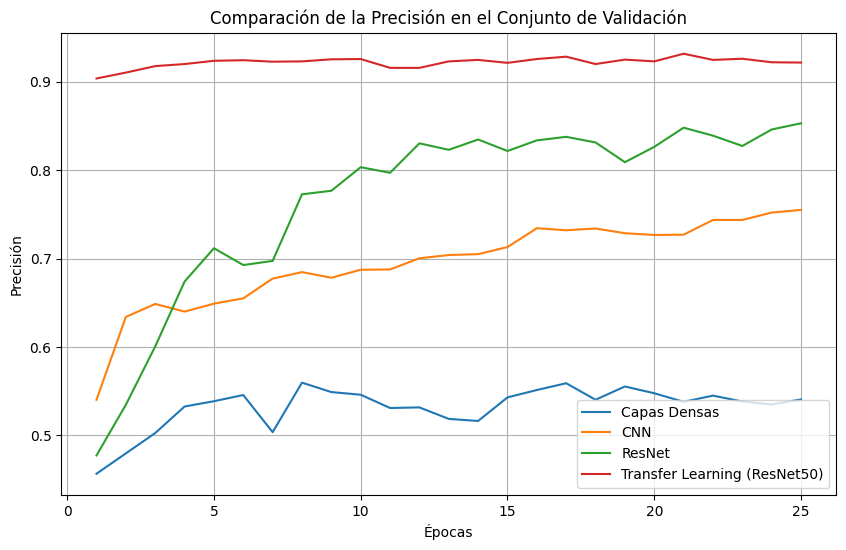

In [17]:
epochs_dense = range(1, len(dense_history.history['val_accuracy']) + 1)
epochs_cnn = range(1, len(cnn_history.history['val_accuracy']) + 1)
epochs_resnet = range(1, len(resnet_history.history['val_accuracy']) + 1)
epochs_tl = range(1, len(tl_history.history['val_accuracy']) + 1)

plt.figure(figsize=(10, 6))

# Graficamos la precisión de validación de cada modelo
plt.plot(epochs_dense, dense_history.history['val_accuracy'], label='Capas Densas')
plt.plot(epochs_cnn, cnn_history.history['val_accuracy'], label='CNN')
plt.plot(epochs_resnet, resnet_history.history['val_accuracy'], label='ResNet')
plt.plot(epochs_tl, tl_history.history['val_accuracy'], label='Transfer Learning (ResNet50)')

plt.title('Comparación de la Precisión en el Conjunto de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

## Comparación de la Pérdida

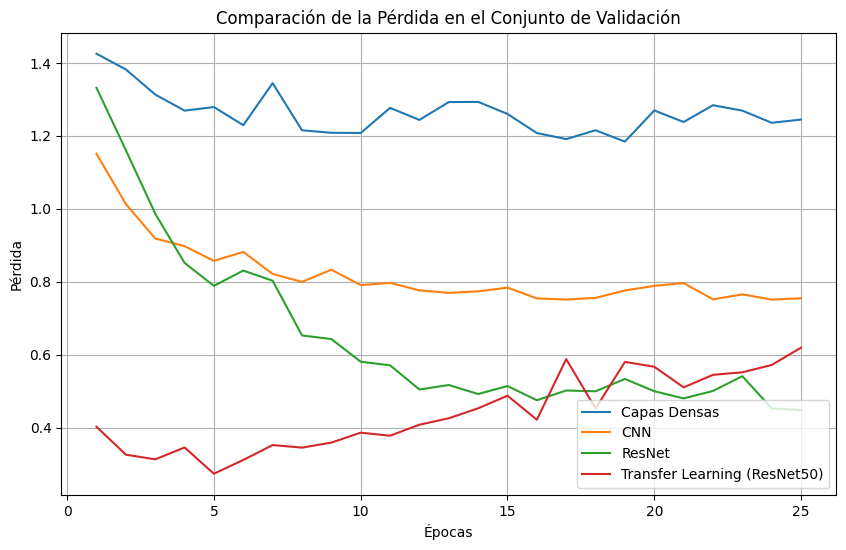

In [18]:
plt.figure(figsize=(10, 6))

# Graficamos la pérdida de validación de cada modelo
plt.plot(epochs_dense, dense_history.history['val_loss'], label='Capas Densas')
plt.plot(epochs_cnn, cnn_history.history['val_loss'], label='CNN')
plt.plot(epochs_resnet, resnet_history.history['val_loss'], label='ResNet')
plt.plot(epochs_tl, tl_history.history['val_loss'], label='Transfer Learning (ResNet50)')

plt.title('Comparación de la Pérdida en el Conjunto de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

## Conclusión

Vemos como el modelo de Transfer Learning basado en ResNet50 tiene el mejor rendimiento tanto en precisión como en pérdida.

Esto es lo que se esperaba ya que el modelo aprovecha características aprendidas de un conjunto de datos preentrenado mucho más extenso (ImageNet).

Los modelos con capas densas y CNN también ofrecen buenos resultados, pero con una precisión y estabilidad ligeramente menores.